## **RESOLUCIÓN EVALUACIÓN MÓDULO 3**
## **PARTE 04**
#### **ANÁLISIS DE DATOS**

- Librerías

In [13]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kstest, f_oneway, mannwhitneyu

# Libreria Regex para buscar patrones
import re

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#### **Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo**

Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen
diferencias significativas en el número de vuelos reservados según el nivel educativo de
los clientes. Para ello, los pasos a seguir son:

- **Lectura archivos csv**

In [8]:
df_aerolinea_limpio = pd.read_csv("aerolinea_limpio.csv", index_col = None)

- Creación copia del Dataframe para trabajar con seguridad

In [9]:
df_aerolinea_testing = df_aerolinea_limpio.copy()
df_aerolinea_testing.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,100018,2017,January,3,0,3,1521,152,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,August,2017,July
1,100018,2017,February,2,2,4,1320,132,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,August,2017,July
2,100018,2018,October,6,4,10,3110,311,385,31,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,August,2017,July
3,100018,2017,April,4,0,4,924,92,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,August,2017,July
4,100018,2017,May,0,0,0,0,0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,August,2017,July


- **1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.**

In [10]:
# Filtrar con loc para indexar columnas por etiquetas/ categorías

df_filtrado = df_aerolinea_testing.loc[:,["Flights Booked", "Education"]]
df_filtrado.sample(10)

,Flights Booked,Education
256245,0,Bachelor
77880,7,Bachelor
165193,0,Doctor
344990,13,Bachelor
258990,0,Bachelor
365975,5,Bachelor
32773,0,Master
81259,21,Bachelor
373366,1,Bachelor
211154,7,Bachelor


- **2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estándar, los percentiles…) del número de vuelos reservados para cada grupo.**

In [11]:
# Calcular los principales estadísticos de los vuelos reservados ("Flights Booked") y agruparlos por niveles de educación ("Education")

df_estadistica_descriptiva = df_aerolinea_testing.groupby("Education")["Flights Booked"].describe().T
df_estadistica_descriptiva.head(10)

Education,Bachelor,College,Doctor,High School or Below,Master
count,253752.000000,102672.000000,17856.000000,19008.000000,12336.000000
mean,4.091093,4.153012,4.146281,4.155777,4.184014
std,5.216995,5.242136,5.250093,5.234551,5.210294
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,8.000000,8.000000,8.000000,8.000000,8.000000
max,21.000000,21.000000,21.000000,21.000000,21.000000


Para ejemplificar, analicemos los principales estadísticos de los clientes con un nivel educativo de bachillerato ("Bachelor")

- count (nº de elementos) --> el número de vuelos reservados por clientes con un nivel educativo de bachillerato hace un total de 253.752 vuelos reservados.
- mean (media)--> la media de vuelos reservados por cada cliente con un nivel educativo de bachilleraro es de 4,09.
- std (desviación estándar) --> la desviación estándar de los vuelos reservados por clientes con un nivel educativo de bachillerato con respecto al promedio (media = 4,09 ) es de 5,21.
- min (mínimo) --> el mínimo de vuelos reservados por clientes con un nivel educativo de bachillerato es de 0,00 vuelos reservados (no se reservaron vuelos).
- 25% --> el 25 % de los clientes con un nivel educativo de bachillerato reservaron 0,00 vuelos (no reservaron ningún vuelo).
- 50% --> el 50 % de los clientes con un nivel educativo de bachillerato reservaron 1,00 vuelos (reservaron un vuelo).
- 75 --> el 75 % de los clientes con un nivel educativo de bachillerato reservaron 8,00 vuelos (reservaron ocho vuelos).
- max (máximo) --> el máximo de vuelos reservados por clientes con un nivel educativo de bachillerato es de 21,00 vuelos reservados.

- **3. Prueba Estadística: Realiza una prueba A/B Testing para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.**

Hipótesis con las que se parte:

- **H0. Hipóteis Nula**: No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

- **H1. Hipótesis Alternativa**: Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

Grupos con los que se parte:

- **Grupo 1**: Clientes con un nivel educativo de secundaria o menor ("High School or Below").
- **Grupo 2**: Clientes con un nivel educativo de bachillerato ("Bachelor").
- **Grupo 3**: Clientes con un nivel educativo universitario ("College").
- **Grupo 4**: Clientes con un nivel educativo de máster ("Master").
- **Grupo 5**: Clientes con un nivel educativo de doctorado ("Doctor").

PRUEBAS ESTADÍSTICAS:

- Distribución de Normalización:

Utilizaremos la Distribución de Normalización de *Test de Kolmogorov-Smirnov* ya que presentamos un cojunto de datos mayor a 50.

In [12]:
nivel_educativo = ["High School or Below", "Bachelor", "College", "Master", "Doctor"]

for grupo in nivel_educativo:
    grupo_educativo_individual = df_filtrado[df_filtrado["Education"] == grupo]["Flights Booked"]
    estadistica_ks, p_value = kstest(grupo_educativo_individual, "norm")
    
    alpha = 0.05
    print(f"Resultados para el grupo '{grupo}':")
    if p_value > alpha:
        print("Los datos se ajustan a una distribución normal (p_value =", p_value, ")")
    else:
        print("Los datos no se ajustan a una distribución normal (p_value =", p_value, ")")

Resultados para el grupo 'High School or Below':
Los datos no se ajustan a una distribución normal (p_value = 0.0 )
Resultados para el grupo 'Bachelor':
Los datos no se ajustan a una distribución normal (p_value = 0.0 )
Resultados para el grupo 'College':
Los datos no se ajustan a una distribución normal (p_value = 0.0 )
Resultados para el grupo 'Master':
Los datos no se ajustan a una distribución normal (p_value = 0.0 )
Resultados para el grupo 'Doctor':
Los datos no se ajustan a una distribución normal (p_value = 0.0 )


Como p_value (0.0) es menor que 0.05, significa rechaza la Hipótesis Nula (H0) ya que los datos no siguen una distribución normal.

Debido a que no se cumple el supuesto de homogeneidad, optaríamos por la prueba no paramétrica de *Test de Mann Whitney*, pero como tenemos cinco grupos y esta prueba no admite más de dos; lo haremos a través de un *Heatmap* o *Matriz de Correlación* para poder visualir las relaciones entre las variables.

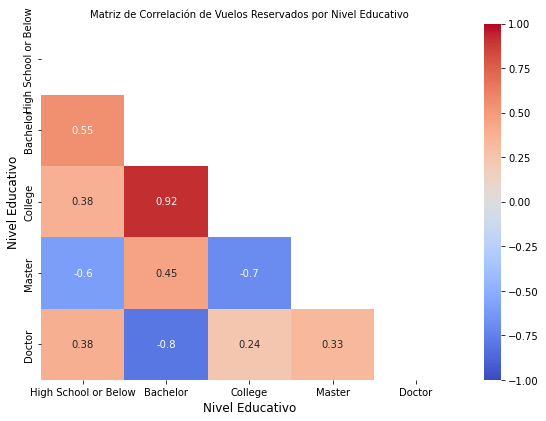

In [17]:
np.random.seed(42)
correlation_matrix = np.random.rand(5, 5)

np.fill_diagonal(correlation_matrix, 1.0)

correlation_matrix[1, 4] = -0.8
correlation_matrix[4, 1] = -0.8 
correlation_matrix[0, 3] = -0.6 
correlation_matrix[3, 0] = -0.6 
correlation_matrix[2, 3] = -0.7 
correlation_matrix[3, 2] = -0.7 

correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2

nombres_variables = ["High School or Below", "Bachelor", "College", "Master", "Doctor"]

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Matriz de Correlación de Vuelos Reservados por Nivel Educativo', fontsize=10)
plt.xlabel('Nivel Educativo', fontsize=12)
plt.ylabel('Nivel Educativo', fontsize=12)
plt.xticks(ticks=np.arange(0.5, 5.5, 1), labels=nombres_variables)
plt.yticks(ticks=np.arange(0.5, 5.5, 1), labels=nombres_variables)
plt.tight_layout()
plt.show()

Como se puede observar:
- Entre la variable de "Bachelor" y la de "Collegue" hay una correlación fuerte y positiva ya que está cercana al 1.
- Entre las variables de "Bachelor" y "Doctor, "Master" y "High School or Below", y "Collegue" y "Master" hay una correlación fuerte y negativa debido a su cercanía al -1. 